# Interpretable Machine Learning
## Exercise Sheet: 9
## This exercise sheet covers chapters 10.1 and 10.2 from the IML book by Christoph Molnar
Kristin Blesch (blesch@leibniz-bips.de)<br>
Niklas Koenen (koenen@leibniz-bips.de)
<hr style="border:1.5px solid gray"> </hr>

# 1) Learned Features

## a) Feature Visualization

**I)** Describe the Feature Visualization method and formulate this method as an optimization problem for a single neuron, a channel, and the entire layer. Which approaches are available for solving this optimization problem?

**Solution:**

Convolutional neural networks have the great advantage that they can work with raw image data and therefore hardly require any feature engineering. This is because the network learns new and increasingly complex features in its layers. Feature Visualization is a method to make the learned features explicit by finding an input that maximizes the activation of a unit. The term “Unit” refers either to individual neurons, channels (also called feature maps), entire layers, or the final class probability.  

Mostly, feature visualization is considered as an optimization problem: We assume that the weights of the network are fixed and we optimize w.r.t. the input image $img \in \mathbb{R}^{C \times H \times W}$. More concrete results for the respective units ($h_{n,x,y,z}$ is the activation of a neuron in layer $n$ channel $z$ at position $x$ and $y$):

- Single neuron at spartial position $x$ and $y$ in layer $n$ channel $z$: $$img^* = \underset{img}{\arg \max}\  h_{n,x,y,z}(img)$$

- Channel $z$ in layer $n$: $$img^* = \underset{img}{\arg \max} \sum_{x,y} h_{n,x,y,z}(img)$$

- Entire layer $n$: $$img^* = \underset{img}{\arg \max} \sum_{x,y, z} h_{n,x,y,z}(img)$$

To solve this problem, one of the two approaches is usually used:  

- Training data: Search through the training images and select those that maximize the activation.

- Image generation: Generate a new image starting from random noise.

**II)** Consider the following neural network with two layers for a classification problem with two classes and input $x \in \mathbb{R}^2$:
$$\text{model}(x) = \text{softmax}\Big( W_2 \cdot \text{ReLU}\big(W_1 \cdot x + b_1 \big) + b_2 \Big)$$

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define model weights and bias
W1 = torch.tensor(
    (( 0.5006,  0.2231),
     (-0.8746, -1.0410),
     ( 0.1379,  0.0027),
     ( 0.0556, -0.3049)))
b1 = torch.tensor((0.5872, 0.9070, -0.6963, 0.2474))

W2 = torch.tensor(
    (( 0.9417, -0.5311, -0.1064, -0.4385),
     (-0.5608,  0.3371, -0.0343, -0.2047)))
b2 = torch.tensor((0.1320, 0.1329))

# Define model
def model(x):
  # First layer
  x = torch.matmul(x, W1.t()) + b1
  x = torch.relu(x)

  # Second layer
  x = torch.matmul(x, W2.t()) + b2
  x = torch.softmax(x, dim = 1)
  
  return x

# Create a n x n grid and the coordinates for the contour plot
n = 100
x, y = np.meshgrid(np.linspace(-10,10,n),np.linspace(-10,10,n))
coords = np.stack((x.reshape(-1), y.reshape(-1)), axis = 1)
coords_torch = torch.tensor(coords, dtype = torch.float)

Instead of optimizing a unit for only one input, we now create a contour plot ([`matplotlib.pyplot.contourf`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html#matplotlib-pyplot-contourf)) to see the activation for all possible inputs from $\mathbb{R}^2$ (this is only possible in this case because the input space is 2-dimensional).  

- Create these plots once for the first neuron in the second layer (before Softmax) and for the second neuron in the first layer (after ReLU).
- Which value solves (globally on the whole plane) the optimization problem in each case, or can this question be answered at all? If not, how is this problem tackled?

**Solution:**

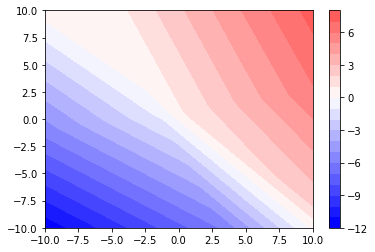

In [3]:
# Function to return the activation of neuron 1 in layer 2 (before softmax)
def get_act_layer2_neuron1(x):
  # First layer
  x = torch.matmul(x, W1.t()) + b1
  x = torch.relu(x)

  # Second layer
  x = torch.matmul(x, W2.t()) + b2

  return x[:,0]

# Create the contour plot

# Get activations for selected unit and convert it from torch to numpy
z = get_act_layer2_neuron1(coords_torch).numpy()
# Reshape z to an n x n matrix
z = z.reshape((n,n))

# Plot the result
plt.contourf(x, y, z, levels = 20, cmap = 'bwr', vmin = -np.max(np.abs(z)), vmax = np.max(np.abs(z)))
plt.colorbar()
plt.show()

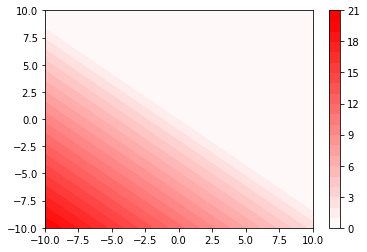

In [4]:
# Function to return the activation of neuron 2 in layer 1 (after ReLU)
def get_act_layer1_neuron2(x):
  # First layer
  x = torch.matmul(x, W1.t()) + b1
  x = torch.relu(x)

  return x[:,1]

# Create the contour plot

# Get activations for selected unit and convert it from torch to numpy
z = get_act_layer1_neuron2(coords_torch).numpy()
# Reshape z to an n x n matrix
z = z.reshape((n,n))

# Plot the result
plt.contourf(x, y, z, levels = 20, cmap = 'bwr', vmin = -np.max(np.abs(z)), vmax = np.max(np.abs(z)))
plt.colorbar()
plt.show()

For both optimization problems, there are no global solutions because the considered activations of the units are unbounded upwards. However, in order to get still meaningful visualizations, the following tricks are often used:  

- Only small steps in the optimization process are allowed
- Penalize too high inputs with L$_1$-regularization
- Noise reduction: apply jittering, rotation or scaling to the image before the optimization step
- Other regularization options include frequency penalization (e.g. reduce variance of neighboring pixels) or generating images with learned priors, e.g. with generative adversarial networks (GANs) or denoising autoencoders 

## b) Network Dissection

**I)** What is the difference between the Feature Visualization and Network Dissection methods?

**Solution:**

The Feature Visualization method generates an input image for a unit that maximizes its activation. This demonstrates (in the best case) what this unit has learned. But often the images are difficult to interpret and contain too abstract features that we cannot understand. These visualizations do not prove that a unit has learned a certain concept. The Network Dissection approach by Bau & Zhou et al. (2017) quantifies the interpretability of a unit of a convolutional neural network. It links highly activated areas of a CNN with human concepts (objects, parts, textures, colors, ...).

**II)** Explain the three steps of the network dissection algorithm.

**Solution:**

**Step 1:** Broaden dataset
- Collect pixel-wise labeled images with concepts of different abstraction levels (from colors to street scenes).
- Bau & Zhou et al. combined a couple of datasets with pixel-wise concepts and called this new dataset ‘Broden’, which stands for broadly and densely labeled data

**Step 2:** Retrieve network activations  
Create the masks of the top activated areas per channel and image. At this point, the concept labels are not yet involved.  
For each convolutional channel $k$:  
1. For each image $x$ in the Broden dataset:  
    a. Forward propagate image $x$ to the target layer containing channel $k$  
    b. Extract the pixel activations of convolutional channel $k$ (feature map): $A_k(x)$
2. Calculate the distribution of pixel activations $a_k$ over all images and spatial location
3. Determine the $0.995$-quantile level $T_k$ of activations $a_k$, i.e. $$\mathbb{P}(a_k > T_k) = 0.005$$
4. For each image $x$ in the Broden dataset:  
    a. Scale the lower-resolution activation map $A_k(x)$ (and pixel-wise qunatile-level $T_k$) to the resolution of image $x$. We call the result $S_k(x)$  
    b. Binarize the activation map: A pixel is either on or off, depending on whether it exceeds the activation threshold $T_k$. The new mask is $M_k(x):= S_k(x) > T_k(x)$
    
**Step 3:** Activation-concept alignment
- After step 2 we have an activation mask per channel and image that marks highly activated areas. For each channel, we want to find the human concept that activates that channel.
- We quantify the alignment between the activation mask of channel $k$ and concept mask $c$ with the **Intersection over Union (IoU)** score (with $|\cdot|$  is the cardinality of the set): $$IoU_{k,c} := \frac{\sum_x \left| M_k(x) \cap L_c(x)\right|}{\sum_x \left| M_k(x) \cup L_c(x)\right|} = \frac{\text{"Area of intersection"}}{\text{"Area of Union"}}$$
- $IoU_{k,c}$ can be interpreted as the accuracy with which unit $k$ detects the concept $c$. We call unit $k$ a **detector of concept $c$** when the IoU is higher than a chosen threshold (Bau & Zhou used $0.04$)

# 2) Pixel Attribution

## a) Theory

**I)** What is the basic idea behind pixel attribution methods and what is the mathematical legitimization of using the gradients to interpret the model prediction?

**Solution:**

Pixel attribution methods highlight the pixels that were relevant for certain image classification by a neural network. In other words, it answers the question "How relevant (positive or negative) is this pixel to the prediction of a chosen class?".  

In general, the prediction function of a neural network for a specific class is highly non-linear for an input image. However, the gradient describes a linear approximation of this function at the input location and thus also the local rate of change, i.e. how much does the prediction change if we minimally change this pixel. In summary, the tangent can be represented as a first-order Taylor expansion that describes the class $c$ prediction function $S_c$ locally at the input image $I$:
$$S_c(I) \approx w^TI + b\quad \text{where} \quad w = \left. \frac{\partial S_c(I_0)}{\partial I_0} \right|_{I_0 = I}$$
Since this is a linear function, some interpretations for a linear model can be applied, at least locally.

**II)** Explain the intuition behind the Grad-CAM method and describe the corresponding algorithm.

**Solution:**

The basic intuitition behind the Grad-CAM method is to understand at which part of an image a (usually high-level) convolutional layer "looks" for a certain classification. It produces a coarse localization map that highlights important regions of the image with respect to the selected output class.

The corresponding algorithm is given by the following steps:
1. Forward propagate the input image through the convolutional neural network
2. Backpropagate the gradient of the class of interest to the last convolutional layer before the fully connected layer: $\frac{\partial y^c}{\partial A^k}$
3. Weight each feature map “pixel” by the gradient for the class. Indices $i$ and $j$ refer to the width and height dimensions and $Z$ is the total number of pixels in the feature map: (This means the gradients are globally pooled) 
    
    $$\alpha_k^c = \overbrace{\frac{1}{Z}\sum_{i}\sum_{j}}^{\text{global average pooling}} \underbrace{\frac{\delta y^c}{\delta A_{ij}^k}}_{\text{gradients via backprop}}$$
    
4. Calculate the localization map 
    
    $$L^c_{Grad-CAM} \in \mathbb{R}^{u\times v} = \underbrace{ReLU}_{\text{Pick positive values}}\left(\sum_{k} \alpha_k^c A^k\right)$$
    
5. For visualization: Scale values to the interval between 0 and 1. Upscale the image and overlay it over the original image.

## b) Programming exercise
In this task, we use the pretrained network [Inception v3](https://arxiv.org/abs/1512.00567) in `torch` and `torchvision` to apply some pixel attribution methods on the following image:

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

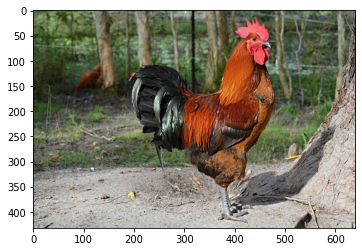

In [5]:
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
     transforms.Resize((299,299))])

# Define plot function for torch.tensors of form (1, C, H, W)
def plot_image(x):
  # take the sum of the absolut values over the channels
  x = x[0,].abs().sum(dim = 0)
  # convert it to numpy and transform it to make artifacts more explicit
  x = x.numpy()**0.75
  plt.imshow(x)
  plt.show()

# Load and preprocess image
img = Image.open('imagenet_rooster.png') # Make sure that the image is in your working directory!!!
x = transform(img)  # Preprocess image
x = x.unsqueeze(0)

# Get model from torchvision
model = models.inception_v3(pretrained = True)
model.eval()

# Show image
plt.imshow(img)
plt.show()

**I)** Calculate the prediction for the image for the Inception v3 model as a probability and output the index with the highest probability. Hint: The model outputs the pre-softmax values, i.e. the last layer has no activation function.  
**Bonus:** What label does this index correspond to?

**Solution:**

In [6]:
out = model(x)
idx = torch.argmax(out).numpy()
print("Probability: {:.2f}%".format(torch.softmax(out, dim = 1)[0,idx].detach().numpy()*100))
print("Index: {}".format(idx))

Probability: 96.37%
Index: 7


Bonus: The corresponding class label is 'cock' (see [here](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a))

**II)** Apply the Vanilla Gradient method to the image for the model output with the highest probability from the last subtask. Plot your result.  
**Hint:** For a scalar output `out`, the method `out.backward()` calculates the gradients of the output with respect to the inputs `input`. Afterwards the gradients can be output with `input.grad`.

**Solution:**

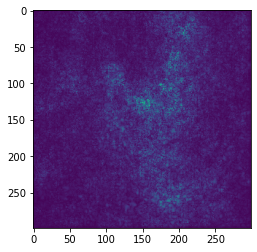

In [7]:
# Clone the torch-converted image
input = x.clone()
# Tell torch to track the gradients for this value
input.requires_grad = True

# Get output for the index '7'
out = model(input)[0,7]
# Backward call to calculate the gradients
out.backward()
# Get the gradients of our output w.r.t. the input
grad = input.grad
# Plot the result
plot_image(grad)

**III)** Apply the Grad-CAM method to the image for the model output with the highest probability from task **I)** and plot your result.

**Solution:**

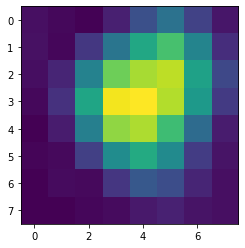

In [8]:
# We need to define a hook to calculate the gradients of the output w.r.t. the last convolutional layer.
# Hooks are executed in addition to the forward pass and in this case only the input is stored.
hook = {}
def get_input_hook(self, input, output):
  hook['input'] = input[0]

# We add the defined hook in the layer 'avgpool' which is the first non-colvolutional layer and its input 
# is of size (*, 2048, 8, 8)
model.avgpool.register_forward_hook(get_input_hook)

# Clone the torch-converted image and tell torch to track the gradients for this input
input = x.clone()
input.requires_grad = True

# to do (start) ----------------------------------------------------------------

# get the model output with the highest class probability
out = model(input)[0,7]

# Calculate gradients w.r.t to the last convolutional layer
grad_A_k = torch.autograd.grad(out, hook['input'])[0]

# Calculate a_k
a_k = grad_A_k.mean(dim = (2,3), keepdim = True)

# Get the feature maps A_k (stored in the forward-hook)
A_k = hook['input'].detach()

# Calculate the localization map (ReLU(sum(a_k * A_k)))
grad_cam = torch.relu((A_k * a_k).sum(dim = 1, keepdim = True))

# to do (end) ------------------------------------------------------------------

# Plot the result
plot_image(grad_cam)

**IV)** Combine both previous results in the Guided Grad-CAM method and plot your result. Use the function [`torch.nn.Upsample`](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html#torch.nn.Upsample) for upsampling the Grad-CAM result.

**Solution:**

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


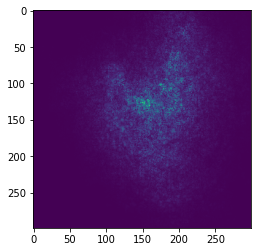

In [9]:
# Upsample the Grad-CAM result to size (1,1,299,299)
grad_cam = torch.nn.Upsample(size = (299,299), mode = "bilinear")(grad_cam)
# Multiply heatmaps
guided_grad_cam = grad_cam * grad

# Plot result
plot_image(guided_grad_cam)